In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install holidays
import holidays
from scipy.stats import skew
from scipy.stats import kurtosis

In [3]:
# Define file pathname
#base = "/Users/ziadharmanani/Documents/GitHub/INF1340-Ridership/Ridership-Data/Bike share ridership "
base = "Bike share ridership/Bike share ridership "
extension = [
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06",
    "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    ]

# Define columns order in a list
columns = [
    "Trip Id", "Trip Duration", "Start Station Id", "Start Time",
    "Start Station Name", "End Station Id", "End Time",
    "End Station Name", "Bike Id", "User Type"
    ]

# Used to store file paths
paths = []

# Loop through file extensions and combine them to locate them individually
for month in extension:
    path = base + month + ".csv"
    paths.append(path)

# Used to store the individual data frames
all_dfs = []

# Clean columns (Inconsistencies between 2024 and other years)
# Mismatch beteen the years issued a lot of NaN values. Trip Id was duplicated (2024 had its own).
for file in paths:
    df_temp = pd.read_csv(file, encoding = "latin1")
    df_temp.columns = [col.replace("ï»¿", "").strip() for col in df_temp.columns]

    # Used to clean BOM character for "Trip Id" (2024)
    if "ï»¿Trip Id" in df_temp.columns:
        df_temp["Trip Id"] = df_temp["ï»¿Trip Id"]
        df_temp = df_temp.drop(columns = ["ï»¿Trip Id"])

    #remove extra space in Trip Duration column
    #df.columns = df.columns.str.replace("Trip  Duration", "Trip Duration")
    df_temp.rename(columns={"Trip  Duration": "Trip Duration"}, inplace=True)

    # Reindexes the data frame according to columns list.
    df_temp = df_temp.reindex(columns = columns)
    all_dfs.append(df_temp)

# Concatinate dataframe
df = pd.concat(all_dfs, ignore_index = True)

# Drop "Model" to stay consistent with previous years (Only present in 2024)
df = df.drop(columns = ["Model", "Bike Id"], errors = "ignore")


df = df.set_index("Trip Id")

# NEXT STEPS: Look into Start Station Name and End Station Name.


In [4]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type']

In [5]:
print(f"Start Station Name: {df['Start Station Name'].nunique()}")
print(f"End Station Name: {df['End Station Name'].nunique()}")

Start Station Name: 593
End Station Name: 592


In [6]:
df.isna().sum()

Trip Duration              0
Start Station Id           0
Start Time                 0
Start Station Name    595075
End Station Id          2944
End Time                   0
End Station Name      598563
User Type                  0
dtype: int64

In [7]:
### START TIME
#split start time into 2 columns
df[['Start Date', 'Start Time']] = df['Start Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('Start Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['Start Date'] = pd.to_datetime(df['Start Date'], format = '%m/%d/%Y')

In [8]:
### END TIME
#split start time into 2 columns
df[['End Date', 'End Time']] = df['End Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('End Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['End Date'] = pd.to_datetime(df['End Date'], format = '%m/%d/%Y')

In [9]:
### START TIME
#split date into day/month but keep og column
df['Start Day'] = df['Start Date'].dt.day

df['Start Month'] = df['Start Date'].dt.month

#move start day to the 4th index
col = df.pop('Start Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('Start Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [10]:
### END TIME
#split date into day/month but keep og column
df['End Day'] = df['End Date'].dt.day

df['End Month'] = df['End Date'].dt.month

#move start day to the 4th index
col = df.pop('End Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('End Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,1,1,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,1,1,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,1,1,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,1,1,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [11]:
#create weekday/weekend column
df['Weekday/Weekend'] = df['Start Date'].dt.weekday.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

df.head()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
20148784,840,7022,00:00,2023-01-01,1,1,1,1,2023-01-01,Simcoe St / Queen St W,7703.0,00:14,NaN,Casual Member,Weekend
20148785,722,7399,00:01,2023-01-01,1,1,1,1,2023-01-01,Lower Jarvis / Queens Quay E,7533.0,00:13,Housey St / Dan Leckie Way,Casual Member,Weekend
20148786,1054,7269,00:02,2023-01-01,1,1,1,1,2023-01-01,Toronto Eaton Centre (Yonge St),7076.0,00:20,York St / Queens Quay W,Annual Member,Weekend
20148790,1329,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend
20148791,1291,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend


In [12]:
# Checking if the Weekday/Weekend column is correct in July
df[(df['Weekday/Weekend'] == 'Weekend') & (df['Start Date'].dt.year == 2023) & (df['Start Date'].dt.month == 7)].sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
23458601,1250,7099,15:48,2023-07-29,29,7,29,7,2023-07-29,Cherry St / Mill St,7118.0,16:09,King St W / Bay St (East Side),Casual Member,Weekend
23473469,4850,7164,02:19,2023-07-30,30,7,30,7,2023-07-30,Gould St / Yonge St (Ryerson University),7170.0,03:40,Spadina Ave / Willcocks St,Casual Member,Weekend
22873107,425,7061,03:36,2023-07-08,8,7,8,7,2023-07-08,Dalton Rd / Bloor St W,7144.0,03:43,Palmerston Ave / Vermont Ave,Casual Member,Weekend
22712324,526,7462,20:03,2023-07-01,1,7,1,7,2023-07-01,Richmond St E / Yonge St,7721.0,20:11,NaN,Casual Member,Weekend
23299372,2087,7601,15:35,2023-07-23,23,7,23,7,2023-07-23,Brick Works,7601.0,16:10,Brick Works,Casual Member,Weekend
23069174,2636,7148,10:17,2023-07-15,15,7,15,7,2023-07-15,King St W / Joe Shuster Way,7111.0,11:01,King St W / Douro St,Casual Member,Weekend
23475271,949,7114,08:41,2023-07-30,30,7,30,7,2023-07-30,Carlton St / Parliament St,7131.0,08:57,Taddle Creek Park,Casual Member,Weekend
23284215,743,7313,22:18,2023-07-22,22,7,22,7,2023-07-22,Coxwell Ave / Lake Shore Blvd E,7316.0,22:31,Queen St. E / Spruce Hill Rd.,Casual Member,Weekend
23079163,62,7566,17:30,2023-07-15,15,7,15,7,2023-07-15,Weston Rd / St Clair Ave W - SMART,7565.0,17:31,St Clair Ave W / Gunns Rd,Casual Member,Weekend


In [13]:
# Added a new column Trip Duration (mm:ss)
df['Trip Duration (mm:ss)'] = df['Trip Duration'].apply(lambda x: f"{x // 60}:{x % 60:02d}")

df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss)
Trip Id,,,,,,,,,,,,,,,,
22926180,579,7487,05:19,2023-07-10,10,7,10,7,2023-07-10,Eastwood Rd / Woodbine Ave - SMART,7427.0,05:28,Northern Dancer Blvd / Lake Shore Blvd E,Casual Member,Weekday,9:39
23824188,462,7292,13:38,2023-08-11,11,8,11,8,2023-08-11,Granby St / Church St - SMART,7021.0,13:46,Bay St / Albert St,Casual Member,Weekday,7:42
25116743,1365,7817,19:19,2023-09-25,25,9,25,9,2023-09-25,NaN,7526.0,19:42,Bartlett Parkette,Casual Member,Weekday,22:45
23499598,953,7188,21:47,2023-07-30,30,7,30,7,2023-07-30,Exhibition GO (Atlantic Ave),7542.0,22:03,Queen St W / John St,Casual Member,Weekend,15:53
21704538,557,7033,10:03,2023-05-23,23,5,23,5,2023-05-23,Union Station,7047.0,10:12,University Ave / Gerrard St W (East Side),Casual Member,Weekday,9:17
21375237,769,7004,18:07,2023-05-08,8,5,8,5,2023-05-08,University Ave / Elm St,7259.0,18:20,Lower Spadina Ave / Lake Shore Blvd,Casual Member,Weekday,12:49
26670560,616,7069,02:25,2023-12-30,30,12,30,12,2023-12-30,Queen St W / Spadina Ave,7211.0,02:35,Fort York Blvd / Garrison Rd,Casual Member,Weekend,10:16
23228826,405,7114,07:54,2023-07-21,21,7,21,7,2023-07-21,Carlton St / Parliament St,7006.0,08:01,Bay St / College St (East Side),Casual Member,Weekday,6:45
20302372,2061,7005,12:31,2023-01-23,23,1,23,1,2023-01-23,King St W / York St,7235.0,13:05,Bay St / College St (West Side) - SMART,Casual Member,Weekday,34:21


In [14]:
# Lists that determine what we defined as peak hours
peak_morning = [6, 7, 8, 9]
peak_evening = [15, 16, 17, 18, 19]

# Assign hour the 'Start Time' hour
hours = pd.to_datetime(df['Start Time'], format='%H:%M').dt.hour

# Defined list for a cleaner code 
conditions = [hours.isin(peak_morning), hours.isin(peak_evening)]
choices = ["Morning", "Evening"]

df['Peak Hour'] = np.select(conditions, choices, default = "Off Peak")

df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss),Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
21643123,559,7546,15:50,2023-05-20,20,5,20,5,2023-05-20,Ross St / Cecil St - SMART,7028.0,15:59,Gould St / Mutual St,Casual Member,Weekend,9:19,Evening
25693278,510,7062,16:32,2023-10-19,19,10,19,10,2023-10-19,University Ave / College St (West),7281.0,16:41,Charles St W / Balmuto St - SMART,Casual Member,Weekday,8:30,Evening
22815252,1161,7022,21:48,2023-07-05,5,7,5,7,2023-07-05,Simcoe St / Queen St W,7203.0,22:07,Bathurst St/Queens Quay(Billy Bishop Airport),Casual Member,Weekday,19:21,Off Peak
22041721,569,7389,06:31,2023-06-05,5,6,5,6,2023-06-05,College Park- Gerrard Entrance,7117.0,06:41,640 Bloor Street E,Casual Member,Weekday,9:29,Morning
20632011,89,7028,08:48,2023-03-12,12,3,12,3,2023-03-12,Gould St / Mutual St,7660.0,08:50,285 Victoria St,Casual Member,Weekend,1:29,Morning
23912091,466,7076,16:19,2023-08-14,14,8,14,8,2023-08-14,York St / Queens Quay W,7533.0,16:27,Housey St / Dan Leckie Way,Casual Member,Weekday,7:46,Evening
24362651,534,7047,17:01,2023-08-30,30,8,30,8,2023-08-30,University Ave / Gerrard St W (East Side),7199.0,17:09,College St / Markham St,Casual Member,Weekday,8:54,Evening
20860391,847,7417,15:47,2023-04-05,5,4,5,4,2023-04-05,King St W / Jordan St,7287.0,16:01,Queen St E / Pape Ave - SMART,Casual Member,Weekday,14:07,Evening
24800647,696,7418,22:31,2023-09-14,14,9,14,9,2023-09-14,College Park - Yonge St Entrance,7453.0,22:43,Jarvis St / Maitland Pl,Casual Member,Weekday,11:36,Off Peak


In [15]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'End Date',
 'End Day',
 'End Month',
 'Start Day',
 'Start Month',
 'Start Date',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type',
 'Weekday/Weekend',
 'Trip Duration (mm:ss)',
 'Peak Hour']

In [16]:
order = ['Trip Duration', 'Trip Duration (mm:ss)', 
         'Start Station Id', 'Start Station Name', 'Start Time', 'Start Day', 'Start Month', 'Start Date', 
         'End Station Id', 'End Station Name', 'End Time', 'End Day', 'End Month', 'End Date',
         'User Type', 'Weekday/Weekend', 'Peak Hour']

df = df[order]
#df = df.drop(columns = ["Trip Duration"], errors = "ignore")
df.sample(10)

,Trip Duration,Trip Duration (mm:ss),Start Station Id,Start Station Name,Start Time,Start Day,Start Month,Start Date,End Station Id,End Station Name,End Time,End Day,End Month,End Date,User Type,Weekday/Weekend,Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
21252172,520,8:40,7188,Exhibition GO (Atlantic Ave),09:25,1,5,2023-05-01,7160.0,King St W / Tecumseth St,09:33,1,5,2023-05-01,Casual Member,Weekday,Morning
22602500,833,13:53,7202,Queen St W / York St (City Hall),17:46,27,6,2023-06-27,7023.0,College St / Borden St,18:00,27,6,2023-06-27,Casual Member,Weekday,Evening
23246448,530,8:50,7123,424 Wellington St W,18:22,21,7,2023-07-21,7211.0,Fort York Blvd / Garrison Rd,18:31,21,7,2023-07-21,Casual Member,Weekday,Evening
25527035,235,3:55,7249,Dovercourt Rd / Harrison St (Green P) - SMART,12:57,12,10,2023-10-12,7184.0,Ossington Ave / College St,13:01,12,10,2023-10-12,Casual Member,Weekday,Off Peak
24506220,241,4:01,7006,Bay St / College St (East Side),17:13,4,9,2023-09-04,7816.0,NaN,17:17,4,9,2023-09-04,Casual Member,Weekday,Evening
22746869,2187,36:27,7245,Tecumseth St / Queen St W - SMART,15:42,3,7,2023-07-03,7298.0,Bathurst St / Adelaide St W,16:19,3,7,2023-07-03,Casual Member,Weekday,Evening
21769053,137,2:17,7270,Church St / Dundas St E - SMART,01:11,26,5,2023-05-26,7164.0,Gould St / Yonge St (Ryerson University),01:13,26,5,2023-05-26,Casual Member,Weekday,Off Peak
20194165,1041,17:21,7659,Amroth Ave / Danforth Ave,20:01,7,1,2023-01-07,7603.0,O'Connor Dr / Curity Ave - SMART,20:19,7,1,2023-01-07,Casual Member,Weekend,Off Peak
21899439,2340,39:00,7571,Highfield Rd / Gerrard St E,19:54,30,5,2023-05-30,7411.0,Little Norway Park,20:33,30,5,2023-05-30,Casual Member,Weekday,Evening


In [18]:
# reset numeric variable to categorical
df['Start Station Id']=df['Start Station Id'].astype('category')
df['End Station Id']=df['End Station Id'].astype('category')
df['Start Day']=df['Start Day'].astype('category')
df['End Day']=df['End Day'].astype('category')
df['Start Month']=df['Start Month'].astype('category')
df['End Month']=df['End Month'].astype('category')

In [19]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

#Trip_summary = summary_stats(df, 'Trip Duration (mm:ss)')

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': 17.98991376780887, 'median': 11.45, 'mode': [7.2], 'std_dev': 146.63290742721023}


In [84]:
# function to find outliers using z-score
def find_outliers_zscore(column, threshold=3):
    # remove na values
    series = column.dropna()
    
    mean = series.mean()/60
    std = series.std()/60
    
    z_scores = (series/60 - mean) / std

        # boolean mask
    mask = np.abs(z_scores) > threshold

    # return list of outlier values
    return series[mask].tolist()



outliers = find_outliers_zscore(df["Trip Duration"])

# proportion of outliers
num_outliers = df['Trip Duration'].isin(outliers).sum()
proportion_outliers = num_outliers / len(df)

print(proportion_outliers)


0.015795957335234


In [49]:
# remove outliers

# replace outliers with NaN
df['Trip Duration'] = df['Trip Duration'].mask(df['Trip Duration'].isin(outliers), np.nan)

# drop rows where Trip Duration is NaN
df = df.dropna(subset=['Trip Duration']).reset_index(drop=True)

In [51]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': 15.847835565757384, 'median': 11.45, 'mode': [7.2], 'std_dev': 18.41774166455249}


In [82]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Peak Hour')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

Peak Hour         
Evening    mean                   16.632388
           median                     12.05
           mode                       [7.8]
           std_dev                18.421291
Morning    mean                   12.770837
           median                      10.3
           mode       [0.03333333333333333]
           std_dev                 13.49441
Off Peak   mean                   16.177246
           median                 11.366667
           mode                       [7.2]
           std_dev                19.738693
Name: Trip Duration, dtype: object


In [83]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Start Month')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

Start Month         
1            mean                    12.79995
             median                       9.9
             mode       [0.03333333333333333]
             std_dev                13.129628
2            mean                   13.449612
             median                 10.416667
             mode         [7.466666666666667]
             std_dev                13.672272
3            mean                   13.233047
             median                      10.3
             mode         [5.816666666666666]
             std_dev                13.008713
4            mean                    15.65183
             median                      11.2
             mode         [7.033333333333333]
             std_dev                17.932853
5            mean                   17.645312
             median                 12.316667
             mode         [7.416666666666667]
             std_dev                21.099279
6            mean                   17.102112
             

In [52]:
# calculate proportion of missing values in dataset
def missing_proportion(df):
# return proportion of missing values
    return df.isna().mean()

missing_prop = missing_proportion(df)

print(missing_prop)

Trip Duration            0.000000
Trip Duration (mm:ss)    0.000000
Start Station Id         0.000000
Start Station Name       0.104146
Start Time               0.000000
Start Day                0.000000
Start Month              0.000000
Start Date               0.000000
End Station Id           0.000508
End Station Name         0.104727
End Time                 0.000000
End Day                  0.000000
End Month                0.000000
End Date                 0.000000
User Type                0.000000
Weekday/Weekend          0.000000
Peak Hour                0.000000
Holiday                  0.000000
rowid                    0.000000
dtype: float64


In [53]:
# run skew and kurtosis
def skew_kurtosis_all(df):
    numeric_df = df.select_dtypes(include=['number'])

    return pd.DataFrame({
        "skew": numeric_df.skew(),
        "kurtosis": numeric_df.kurtosis()
    })

skew_kurtosis_df = skew_kurtosis_all(df)

print(skew_kurtosis_df)

                   skew   kurtosis
Trip Duration  7.417947  99.025541
rowid          0.000092  -1.200207


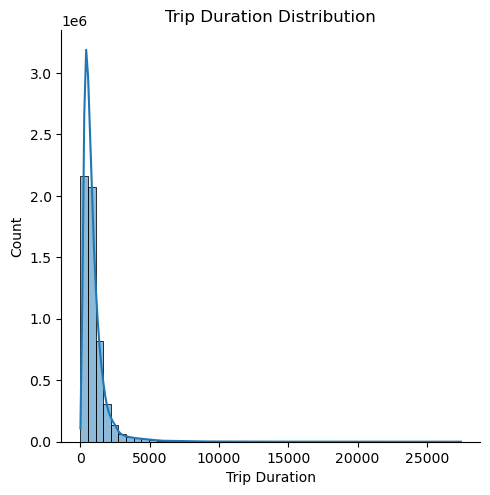

In [73]:
# visualize the distribution of the numeric variables

#plot trip duration
sns.displot(data=df, x='Trip Duration', kind='hist', kde='show', bins = 50)
plt.title('Trip Duration Distribution')

plt.show()

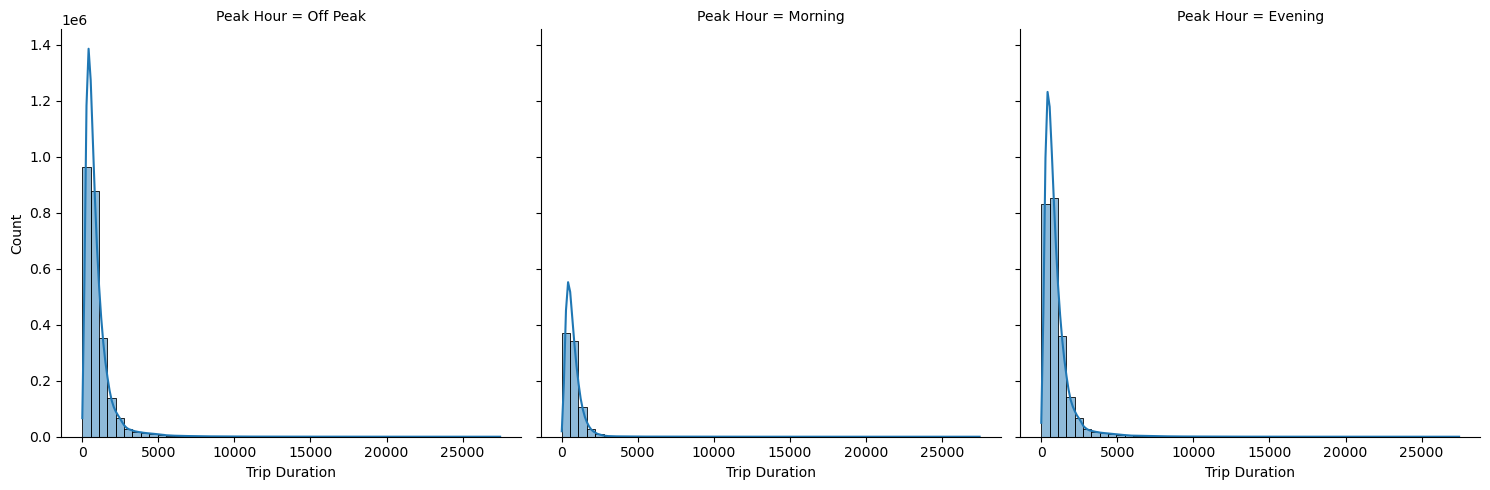

In [74]:
#plot 
sns.displot(data=df, x='Trip Duration', col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

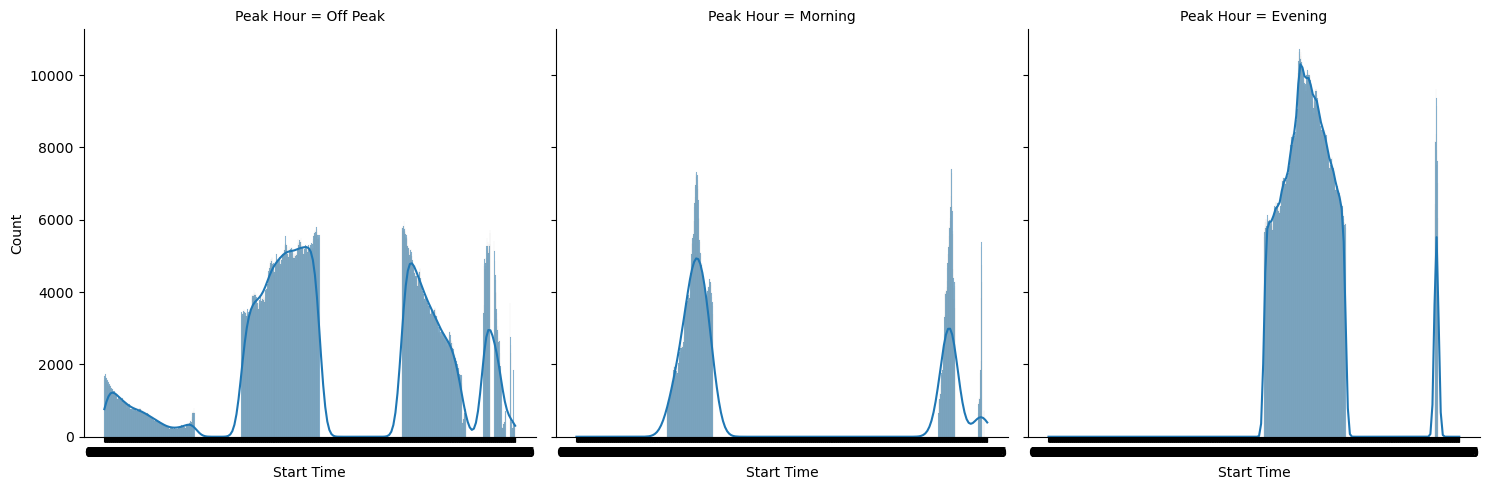

In [69]:
#plot 
sns.displot(data=df, x='Start Time', col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

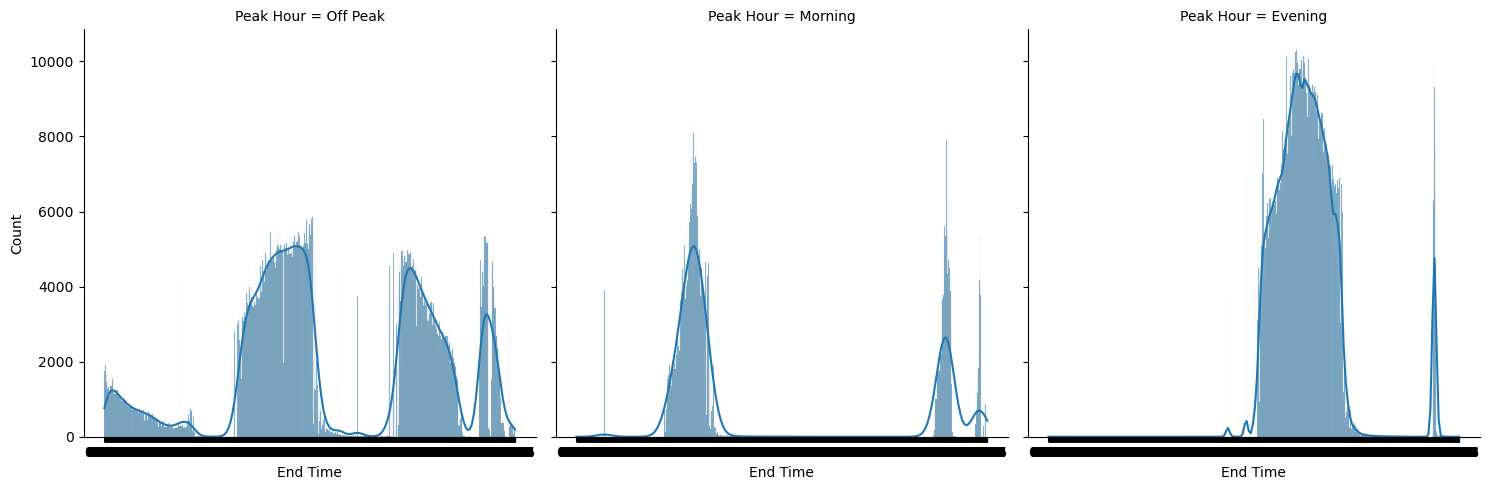

In [70]:
#plot 
sns.displot(data=df, x='End Time',col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

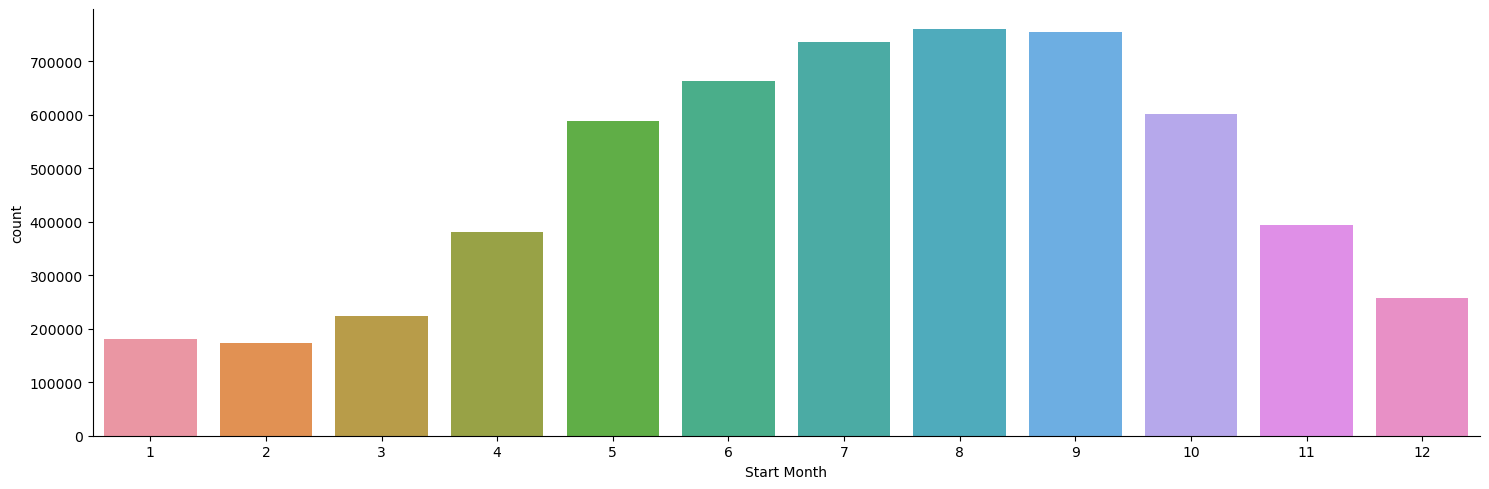

In [38]:
# plot categorical variable
sns.catplot(data=df, x='Start Month', kind='count', aspect = 3)
plt.title('Count of Bike Trips in Each Month')

plt.show()

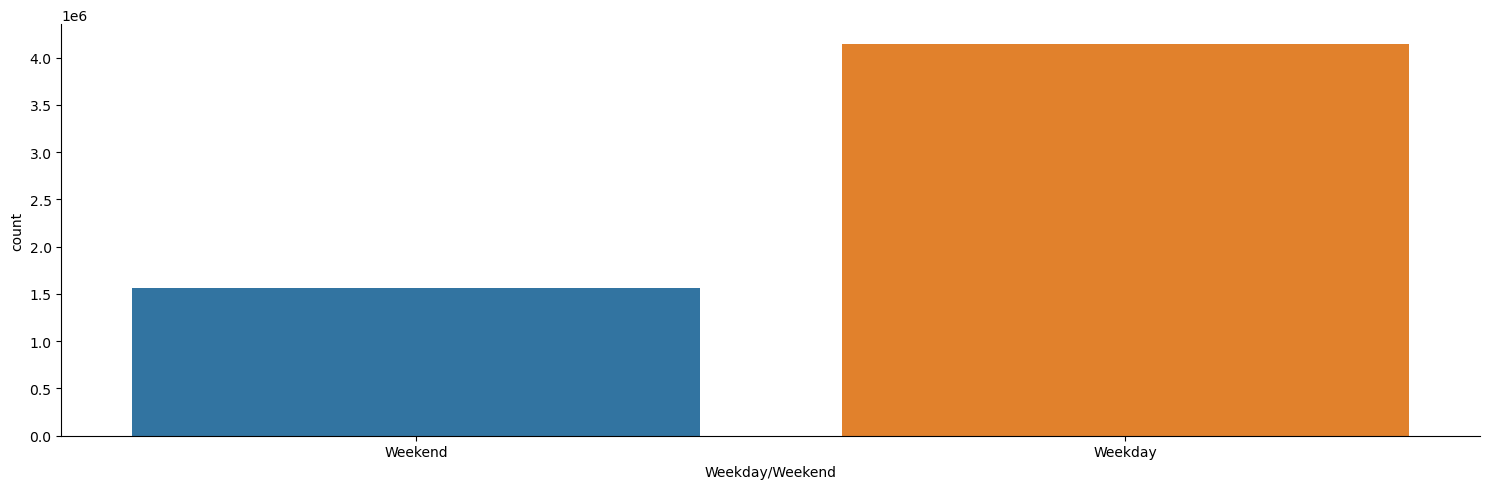

In [57]:
# plot categorical variable
sns.catplot(data=df, x='Weekday/Weekend', kind='count', aspect = 3)
plt.title('Count of Weekday Bike Trips')

plt.show()

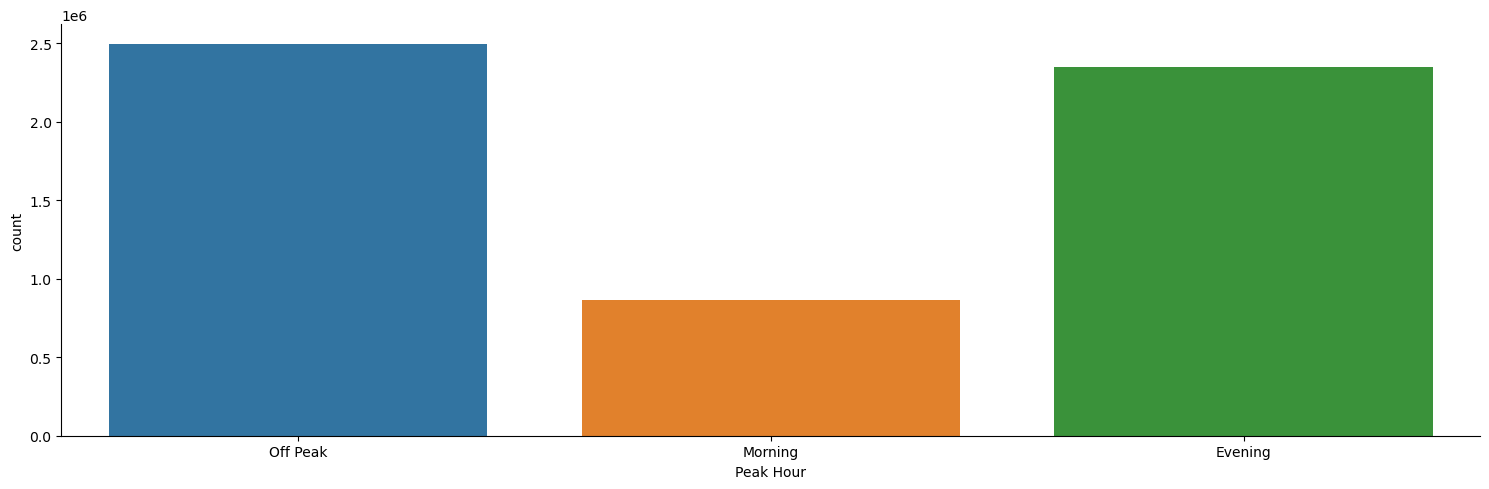

In [58]:
# plot categorical variable
sns.catplot(data=df, x='Peak Hour', kind='count', aspect = 3)
plt.title('Count of Peak Hours Bike Trips')

plt.show()

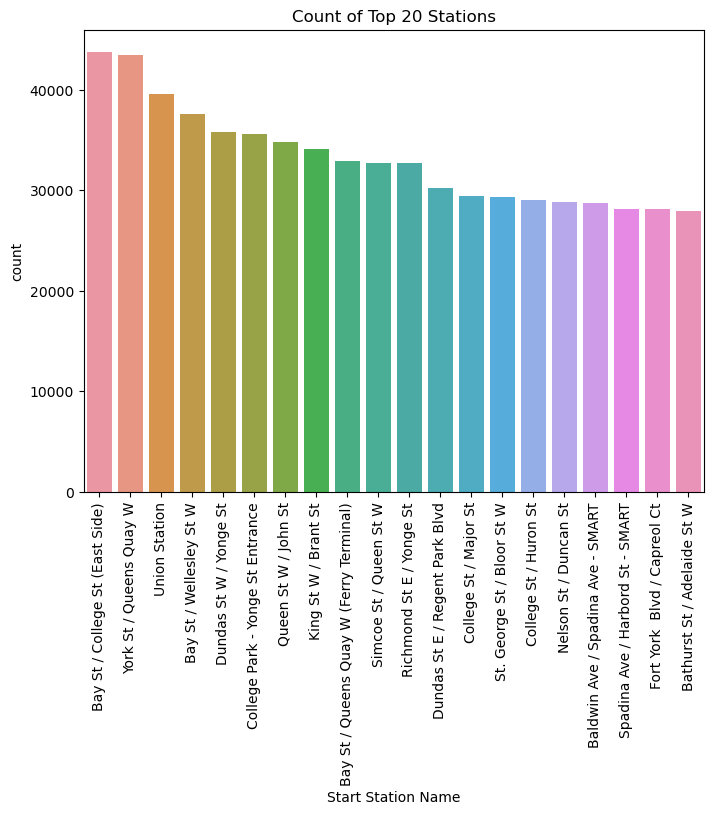

In [ ]:
top_20_Stations = df['Start Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['Start Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='Start Station Name', order=top_20_Stations)
plt.title('Count of Top 20 Start Stations')
plt.xticks(rotation='vertical')
plt.show()


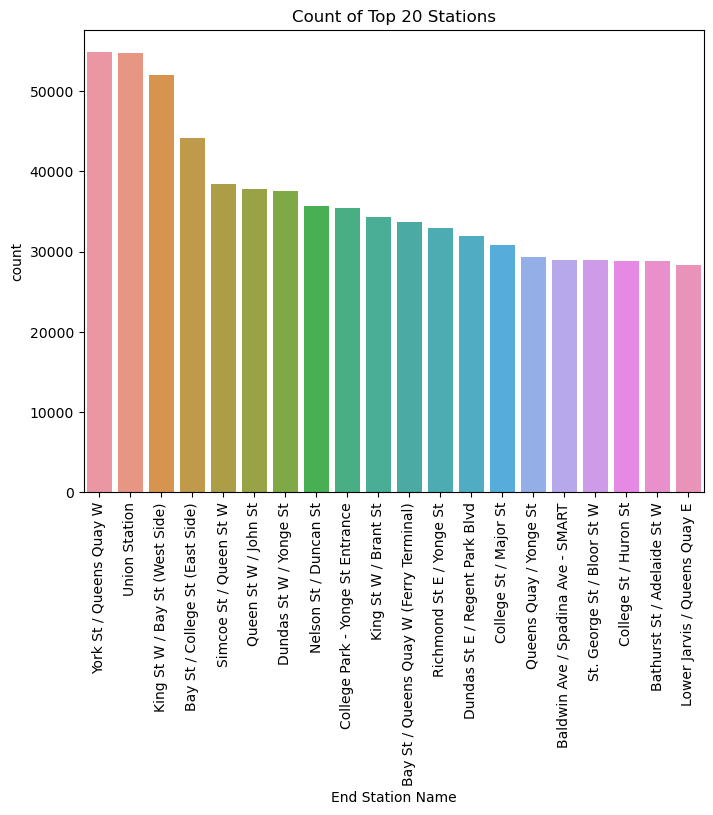

In [ ]:
top_20_Stations = df['End Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['End Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='End Station Name', order=top_20_Stations)
plt.title('Count of Top 20 End Stations')
plt.xticks(rotation='vertical')
plt.show()